In [2]:
# Script to test out different parameters and see what effect this has on the model

import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pandas.io.stata import StataParser
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib
import google_trends_daily.gtrend as gtrend

from sklearn.model_selection import train_test_split
import platform

import RF
import lstm
import linear
import postprocessing
import platform
# Making a new preprocessing file so I can mess with the inputs/outputs
import preprocessing_for_variation as prep


In [3]:

# Just for reference for the JHU data files
startOfCovid = '1/22/20' # The first day where data has been recorded
endOfCovid = '10/30/21' # The last day of relevance to this project
# NOTE delay can be a maximum of 30 because of this end date and the way I load all the data at once

# Step 1: Get the trends data for a very large timeframe so we can pre-load this and not web-scrape each time

xDateFormat = '%Y-%m-%d'
if platform.system() == 'Windows':
    yDateFormat = '%#m/%#d/%y'
else:
    yDateFormat = '%-m/%-d/%y'

# Using a delay of 16 days
startDateX = '2020-02-01'
endDateX = '2021-09-30'
delay = timedelta(days=6)
startDateY = (datetime.strptime(startDateX, xDateFormat) + delay).strftime(xDateFormat) # these should be in xdate format
endDateY = (datetime.strptime(endDateX, xDateFormat) + delay).strftime(xDateFormat)
geo = 'US-CA'
state = 'California'


X_all, Y_all_6delay, Y_all = prep.getDataNew(startDateX, endDateX, startDateY, endDateY, geo, state)
# X_all is the search term data for the entire giant period
# Y_all_6delay is the case data for the entire period, with the delay included


Fetching 'covid' for period:2021-01-04 2021-09-30
Fetching 'covid' for period:2020-07-19 2021-04-14
Normalize by overlapping period:2021-01-04 2021-04-14
Fetching 'covid' for period:2020-02-01 2020-10-27
Normalize by overlapping period:2020-07-19 2020-10-27
Fetching 'covid' for period:2019-08-16 2020-05-11
Normalize by overlapping period:2020-02-01 2020-05-11
Fetching 'coronavirus' for period:2021-01-04 2021-09-30
Fetching 'coronavirus' for period:2020-07-19 2021-04-14
Normalize by overlapping period:2021-01-04 2021-04-14
Fetching 'coronavirus' for period:2020-02-01 2020-10-27
Normalize by overlapping period:2020-07-19 2020-10-27
Fetching 'coronavirus' for period:2019-08-16 2020-05-11
Normalize by overlapping period:2020-02-01 2020-05-11
Fetching 'covid-19' for period:2021-01-04 2021-09-30
Fetching 'covid-19' for period:2020-07-19 2021-04-14
Normalize by overlapping period:2021-01-04 2021-04-14
Fetching 'covid-19' for period:2020-02-01 2020-10-27
Normalize by overlapping period:2020-07

In [4]:

# Indexing this by date as well:
sdate = datetime.strptime(startDateX, xDateFormat)
edate = datetime.strptime(endDateX, xDateFormat)
dates = pd.date_range(sdate,edate,freq='d')
dateList = dates.strftime(xDateFormat).to_list()
X_all_dateIndexed = X_all.copy(deep=True)
X_all_dateIndexed['dates'] = dateList
X_all_dateIndexed = X_all_dateIndexed.set_index('dates')
# Y is already indexed by date, but needs to be converted to datetime form
Y_all_6delay.index = pd.to_datetime(Y_all_6delay.index)
Y_all.index = pd.to_datetime(Y_all.index)



In [19]:

# Varying the split percentage for train and test ############################################################

# Get a subset of data based on a smaller timeframe (let this be a 4 month period)

# X_all is indexed by day number, rather than the date itself
# So, index X_all by the actual dates rather than just integers


startDate_subset_X = '2020-02-01'
endDate_subset_X = '2020-06-01'
startDate_subset_Y = '2/07/20'
endDate_subset_Y = '6/07/20'

X = X_all_dateIndexed[startDate_subset_X:endDate_subset_X]
Y = Y_all_6delay[startDate_subset_Y:endDate_subset_Y]

rmsdata_varyTrainPct = [] # initialize

percentages = [0.5, 0.6, 0.7, 0.8, 0.9]

for train_percentage in percentages:
    split_idx = round(len(Y)*train_percentage)
    print(f'split idx in my code: {split_idx}')
    # Linear regression
    linear_predict = linear.linear(X, Y, train_percentage)
    print('Y[splitidx:] size= ')
    print(Y[split_idx:].size)
    print('linear_predict len')
    print(len(linear_predict))
    linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
    # LSTM
    lstm_predict = lstm.lstm(X, Y, train_percentage)
    lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
    # RF
    RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
    RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
    RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

    rmsdata_varyTrainPct.append([train_percentage, linear_rms, lstm_rms, RF_rms])
    # Store the rms data 

trainPct_df = pd.DataFrame(rmsdata_varyTrainPct, columns=['Train %', 'Linear Regression', 'LSTM', 'Random Forest'])
trainPct_df.set_index('Train %')
trainPct_df.style.set_caption('Varying the Train/Test Split (Train Percentage): Effects on MAPE')
print(trainPct_df)



split idx in my code: 61
(122, 11)
(61, 11)
(61, 11)
Y[splitidx:] size= 
61
linear_predict len
61
Epoch 1/200
1/1 - 2s - loss: 0.4044 - val_loss: 0.6615 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.3901 - val_loss: 0.6464 - 25ms/epoch - 25ms/step
Epoch 3/200
1/1 - 0s - loss: 0.3757 - val_loss: 0.6311 - 23ms/epoch - 23ms/step
Epoch 4/200
1/1 - 0s - loss: 0.3613 - val_loss: 0.6159 - 22ms/epoch - 22ms/step
Epoch 5/200
1/1 - 0s - loss: 0.3469 - val_loss: 0.6005 - 23ms/epoch - 23ms/step
Epoch 6/200
1/1 - 0s - loss: 0.3324 - val_loss: 0.5851 - 23ms/epoch - 23ms/step
Epoch 7/200
1/1 - 0s - loss: 0.3178 - val_loss: 0.5695 - 23ms/epoch - 23ms/step
Epoch 8/200
1/1 - 0s - loss: 0.3031 - val_loss: 0.5538 - 23ms/epoch - 23ms/step
Epoch 9/200
1/1 - 0s - loss: 0.2883 - val_loss: 0.5380 - 22ms/epoch - 22ms/step
Epoch 10/200
1/1 - 0s - loss: 0.2733 - val_loss: 0.5220 - 24ms/epoch - 24ms/step
Epoch 11/200
1/1 - 0s - loss: 0.2583 - val_loss: 0.5058 - 23ms/epoch - 23ms/step
Epoch 12/200
1/1 - 0s - 

In [20]:
trainPct_df

,Train %,Linear Regression,LSTM,Random Forest
0,0.5,0.644022,0.623108,0.858082
1,0.6,0.482111,0.596852,0.901564
2,0.7,0.250784,0.374565,0.544085
3,0.8,0.285590,0.336543,0.450305
4,0.9,0.307843,0.320636,0.329707


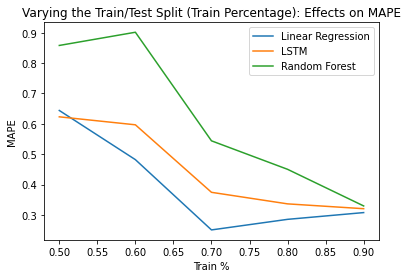

In [49]:

trainPct_df2 = pd.DataFrame(rmsdata_varyTrainPct, columns=['Train %', 'Linear Regression', 'LSTM', 'Random Forest'])
trainPct_df2 = trainPct_df2.set_index('Train %')
#trainPct_df2 = trainPct_df2.style.set_caption('Varying the Train/Test Split (Train Percentage): Effects on MAPE')
ax = trainPct_df2.plot()
ax.set_ylabel("MAPE")
ax.set_title('Varying the Train/Test Split (Train Percentage): Effects on MAPE')
#plt.savefig("plots/split_percent.pdf")

In [6]:

# Change the length of the timeframe being considered ############################################################
durations = [1,2,3,4,5,6,7,8,9] # months

# Arbitrary start date
startDate_subset_X = '2020-02-01'
startDate_subset_Y = '2020-02-07'

rmsdata_varyDuration = [] # initialize

train_percentage = 0.875

for duration in durations:
    dt = timedelta(days=30*duration) # timedelta does not work with months, using 30*months for days
    endDate_subset_X = (datetime.strptime(startDate_subset_X, xDateFormat) + dt).strftime(xDateFormat)
    endDate_subset_Y = (datetime.strptime(startDate_subset_Y, xDateFormat) + dt).strftime(yDateFormat)
    X = X_all_dateIndexed[startDate_subset_X:endDate_subset_X]
    Y = Y_all_6delay[startDate_subset_Y:endDate_subset_Y]
    
    split_idx = round(len(Y)*train_percentage)
    # Linear regression
    linear_predict = linear.linear(X, Y, train_percentage)
    linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
    # LSTM
    lstm_predict = lstm.lstm(X, Y, train_percentage)
    lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
    # RF
    RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
    RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
    RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

    rmsdata_varyDuration.append([duration, linear_rms, lstm_rms, RF_rms])

duration_df = pd.DataFrame(rmsdata_varyDuration, columns=['Duration', 'Linear Regression', 'LSTM', 'Random Forest'])
duration_df.set_index('Duration')
duration_df.style.set_caption('Varying the model duration (months of data): Effects on MAPE')
print(duration_df)



(31, 11)
(27, 11)
(4, 11)
Epoch 1/200
1/1 - 2s - loss: 0.0595 - val_loss: 0.6746 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.0529 - val_loss: 0.6442 - 27ms/epoch - 27ms/step
Epoch 3/200
1/1 - 0s - loss: 0.0497 - val_loss: 0.6165 - 32ms/epoch - 32ms/step
Epoch 4/200
1/1 - 0s - loss: 0.0487 - val_loss: 0.5924 - 39ms/epoch - 39ms/step
Epoch 5/200
1/1 - 0s - loss: 0.0481 - val_loss: 0.5713 - 40ms/epoch - 40ms/step
Epoch 6/200
1/1 - 0s - loss: 0.0476 - val_loss: 0.5524 - 36ms/epoch - 36ms/step
Epoch 7/200
1/1 - 0s - loss: 0.0469 - val_loss: 0.5351 - 32ms/epoch - 32ms/step
Epoch 8/200
1/1 - 0s - loss: 0.0461 - val_loss: 0.5193 - 35ms/epoch - 35ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0452 - val_loss: 0.5045 - 41ms/epoch - 41ms/step
Epoch 10/200
1/1 - 0s - loss: 0.0442 - val_loss: 0.4906 - 36ms/epoch - 36ms/step
Epoch 11/200
1/1 - 0s - loss: 0.0430 - val_loss: 0.4774 - 32ms/epoch - 32ms/step
Epoch 12/200
1/1 - 0s - loss: 0.0418 - val_loss: 0.4649 - 36ms/epoch - 36ms/step
Epoch 13/200
1/

In [7]:
duration_df

,Duration,Linear Regression,LSTM,Random Forest
0,1,0.396846,0.426970,0.540869
1,2,0.671350,0.384689,0.432080
2,3,0.223119,0.222263,0.335136
3,4,0.341558,0.337785,0.372847
4,5,0.419666,0.490878,0.508589
5,6,0.200541,0.235083,0.204856
6,7,0.242672,0.312964,0.344899
7,8,0.454469,0.405501,0.498792
8,9,0.330086,0.339959,0.447035


Text(0.5, 1.0, 'Varying the model duration (months of data): Effects on MAPE')

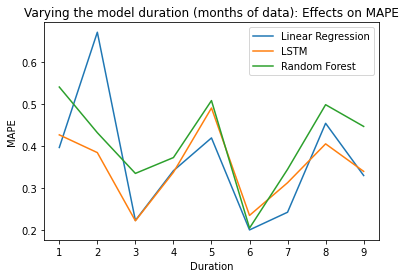

In [8]:
duration_df2 = pd.DataFrame(rmsdata_varyDuration, columns=['Duration', 'Linear Regression', 'LSTM', 'Random Forest'])
duration_df2 = duration_df2.set_index('Duration')
ax = duration_df2.plot()
ax.set_ylabel("MAPE")
ax.set_title('Varying the model duration (months of data): Effects on MAPE')
#plt.savefig("plots/duration.pdf")

In [9]:

# Change the start time ############################################################
startDatesX = ['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01']
dt = timedelta(days=6)
duration = timedelta(days = 6*30)
train_percentage = 0.922222
rmsdata_varyStartDate = []
for sdateX in startDatesX:
    sdateY = (datetime.strptime(sdateX, xDateFormat) + dt).strftime(yDateFormat)
    edateX = (datetime.strptime(sdateX, xDateFormat) + duration).strftime(xDateFormat)
    edateY = (datetime.strptime(sdateX, xDateFormat) + dt + duration ).strftime(yDateFormat)

    X = X_all_dateIndexed[sdateX:edateX]
    Y = Y_all_6delay[sdateY:edateY]
    
    split_idx = round(len(Y)*train_percentage)
    # Linear regression
    linear_predict = linear.linear(X, Y, train_percentage)
    linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
    # LSTM
    lstm_predict = lstm.lstm(X, Y, train_percentage)
    lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
    # RF
    RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
    RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
    RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

    rmsdata_varyStartDate.append([(sdateX+ ' : ' + edateX), linear_rms, lstm_rms, RF_rms])

startDate_df = pd.DataFrame(rmsdata_varyStartDate, columns=['Timeframe', 'Linear Regression', 'LSTM', 'Random Forest'])
startDate_df.set_index('Timeframe')
startDate_df.style.set_caption('Adjusting the timeframe period: Effects on MAPE')
print(startDate_df)




(181, 11)
(167, 11)
(14, 11)
Epoch 1/200
2/2 - 2s - loss: 0.3658 - val_loss: 0.4284 - 2s/epoch - 1s/step
Epoch 2/200
2/2 - 0s - loss: 0.3354 - val_loss: 0.4084 - 28ms/epoch - 14ms/step
Epoch 3/200
2/2 - 0s - loss: 0.3056 - val_loss: 0.3883 - 35ms/epoch - 17ms/step
Epoch 4/200
2/2 - 0s - loss: 0.2792 - val_loss: 0.3683 - 39ms/epoch - 19ms/step
Epoch 5/200
2/2 - 0s - loss: 0.2568 - val_loss: 0.3486 - 38ms/epoch - 19ms/step
Epoch 6/200
2/2 - 0s - loss: 0.2403 - val_loss: 0.3298 - 52ms/epoch - 26ms/step
Epoch 7/200
2/2 - 0s - loss: 0.2285 - val_loss: 0.3119 - 51ms/epoch - 25ms/step
Epoch 8/200
2/2 - 0s - loss: 0.2184 - val_loss: 0.2949 - 44ms/epoch - 22ms/step
Epoch 9/200
2/2 - 0s - loss: 0.2095 - val_loss: 0.2788 - 38ms/epoch - 19ms/step
Epoch 10/200
2/2 - 0s - loss: 0.2021 - val_loss: 0.2639 - 39ms/epoch - 19ms/step
Epoch 11/200
2/2 - 0s - loss: 0.1965 - val_loss: 0.2502 - 39ms/epoch - 19ms/step
Epoch 12/200
2/2 - 0s - loss: 0.1914 - val_loss: 0.2378 - 42ms/epoch - 21ms/step
Epoch 13/200

In [10]:
startDate_df

,Timeframe,Linear Regression,LSTM,Random Forest
0,2020-03-01 : 2020-08-28,0.154071,0.180462,0.189475
1,2020-04-01 : 2020-09-28,0.308431,0.256388,0.209700
2,2020-05-01 : 2020-10-28,0.226556,0.197626,0.192696
3,2020-06-01 : 2020-11-28,0.373418,0.371274,0.337634
4,2020-07-01 : 2020-12-28,0.319516,0.337080,0.318624
5,2020-08-01 : 2021-01-28,0.255443,0.712401,0.208305
6,2020-09-01 : 2021-02-28,0.569391,0.389394,0.827521
7,2020-10-01 : 2021-03-30,1.072203,0.862300,0.532142
8,2020-11-01 : 2021-04-30,1.440276,1.019069,2.485496


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, '2020-11-01 : 2021-04-30'),
  Text(0.0, 0, '2020-03-01 : 2020-08-28'),
  Text(1.0, 0, '2020-04-01 : 2020-09-28'),
  Text(2.0, 0, '2020-05-01 : 2020-10-28'),
  Text(3.0, 0, '2020-06-01 : 2020-11-28'),
  Text(4.0, 0, '2020-07-01 : 2020-12-28'),
  Text(5.0, 0, '2020-08-01 : 2021-01-28'),
  Text(6.0, 0, '2020-09-01 : 2021-02-28'),
  Text(7.0, 0, '2020-10-01 : 2021-03-30'),
  Text(8.0, 0, '2020-11-01 : 2021-04-30'),
  Text(9.0, 0, '')])

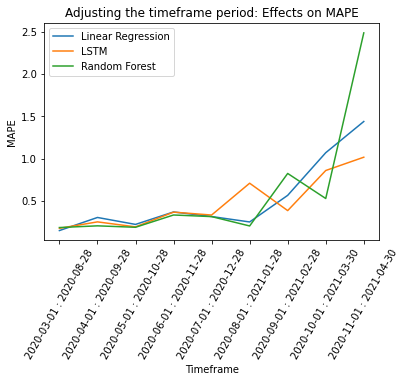

In [11]:
startDate_df2 = pd.DataFrame(rmsdata_varyStartDate, columns=['Timeframe', 'Linear Regression', 'LSTM', 'Random Forest'])
startDate_df2 = startDate_df2.set_index('Timeframe')
ax = startDate_df2.plot()
ax.set_ylabel("MAPE")
ax.set_title('Adjusting the timeframe period: Effects on MAPE')
plt.xticks(rotation=60)
#plt.savefig("plots/dan_sliding_window_dont_use.pdf")

# NOTE: This is the same as Megan's sliding window graph, just use hers

In [13]:

# Change the amount of time delay ############################################################

delays = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
rmsdata_varydelay = []
# Arbitrary start and end dates
sdateX = '2020-05-01'
edateX = '2020-11-01'
train_percentage = 0.922222

for delay in delays:
    dt = timedelta(days=delay)

    sdateY = (datetime.strptime(sdateX, xDateFormat) + dt).strftime(yDateFormat)
    edateY = (datetime.strptime(edateX, xDateFormat) + dt).strftime(yDateFormat)

    X = X_all_dateIndexed[sdateX:edateX]
    Y = Y_all[sdateY:edateY]
    
    split_idx = round(len(Y)*train_percentage)
    # Linear regression
    linear_predict = linear.linear(X, Y, train_percentage)
    linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
    # LSTM
    lstm_predict = lstm.lstm(X, Y, train_percentage)
    lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
    # RF
    RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
    RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
    RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

    rmsdata_varydelay.append([delay, linear_rms, lstm_rms, RF_rms])

delay_df = pd.DataFrame(rmsdata_varydelay, columns=['Delay, days', 'Linear Regression', 'LSTM', 'Random Forest'])
delay_df.set_index('Delay, days')
delay_df.style.set_caption('Adjusting the delay between searches and cases: Effects on MAPE')
print(delay_df)


(185, 11)
(171, 11)
(14, 11)
Epoch 1/200
2/2 - 3s - loss: 0.2367 - val_loss: 0.1954 - 3s/epoch - 2s/step
Epoch 2/200
2/2 - 0s - loss: 0.2159 - val_loss: 0.1744 - 43ms/epoch - 21ms/step
Epoch 3/200
2/2 - 0s - loss: 0.1982 - val_loss: 0.1538 - 49ms/epoch - 24ms/step
Epoch 4/200
2/2 - 0s - loss: 0.1826 - val_loss: 0.1333 - 43ms/epoch - 21ms/step
Epoch 5/200
2/2 - 0s - loss: 0.1687 - val_loss: 0.1132 - 44ms/epoch - 22ms/step
Epoch 6/200
2/2 - 0s - loss: 0.1567 - val_loss: 0.0940 - 58ms/epoch - 29ms/step
Epoch 7/200
2/2 - 0s - loss: 0.1470 - val_loss: 0.0807 - 49ms/epoch - 24ms/step
Epoch 8/200
2/2 - 0s - loss: 0.1401 - val_loss: 0.0738 - 40ms/epoch - 20ms/step
Epoch 9/200
2/2 - 0s - loss: 0.1367 - val_loss: 0.0692 - 50ms/epoch - 25ms/step
Epoch 10/200
2/2 - 0s - loss: 0.1357 - val_loss: 0.0654 - 58ms/epoch - 29ms/step
Epoch 11/200
2/2 - 0s - loss: 0.1361 - val_loss: 0.0624 - 242ms/epoch - 121ms/step
Epoch 12/200
2/2 - 0s - loss: 0.1364 - val_loss: 0.0617 - 97ms/epoch - 48ms/step
Epoch 13/2

In [14]:
delay_df

,"Delay, days",Linear Regression,LSTM,Random Forest
0,0,0.332482,0.301031,0.300768
1,2,0.247814,0.185521,0.233640
2,4,0.234412,0.182638,0.262213
3,6,0.226310,0.191460,0.146241
4,8,0.147397,0.171669,0.189064
5,10,0.162675,0.179001,0.206001
6,12,0.201343,0.232421,0.259509
7,14,0.284690,0.279159,0.345152
8,16,0.330423,0.370949,0.399536
9,18,0.423326,0.468257,0.473317


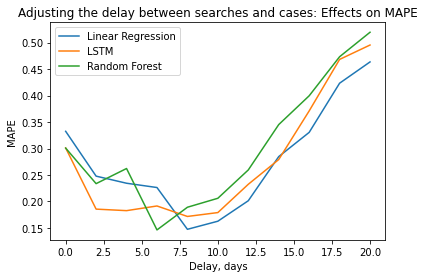

In [15]:
delay_df2 = pd.DataFrame(rmsdata_varydelay, columns=['Delay, days', 'Linear Regression', 'LSTM', 'Random Forest'])
delay_df2 = delay_df2.set_index('Delay, days')
ax = delay_df2.plot()
ax.set_ylabel("MAPE")
ax.set_title('Adjusting the delay between searches and cases: Effects on MAPE')
plt.savefig("plots/delay.pdf")

In [17]:

# Change the state being considered ############################################################
# This will require re-parsing the data from gtrends

other_geos = ['US-OH', 'US-AL', 'US-TX', 'US-IL', 'US-FL']
other_states = ['Ohio', 'Alabama', 'Texas', 'Illinois', 'Florida']

# Setting the timeframe to an arbitrary 4-month period
startDateX = '2020-03-01'
endDateX = '2020-09-01'
delay = timedelta(8)
startDateY = (datetime.strptime(startDateX, xDateFormat) + delay).strftime(xDateFormat) # THESE SHOULD BE IN XDATE FORMAT
endDateY = (datetime.strptime(endDateX, xDateFormat) + delay).strftime(xDateFormat) #  ... because these are passed onto getDataNew()

train_percentage = 0.922222

rmsdata_varyState = []

for i in range(len(other_states)):
    geo = other_geos[i]
    state = other_states[i]

    X, Y, Y_noDelay = prep.getDataNew(startDateX, endDateX, startDateY, endDateY, geo, state)

    split_idx = round(len(Y)*train_percentage)
    # Linear regression
    linear_predict = linear.linear(X, Y, train_percentage)
    linear_rms = postprocessing.MAPE(Y[split_idx:], linear_predict)
    # LSTM
    lstm_predict = lstm.lstm(X, Y, train_percentage)
    lstm_rms = postprocessing.MAPE(Y[split_idx:], lstm_predict)
    # RF
    RF_kwargs = {'bootstrap': True,'criterion': 'squared_error','max_depth': None,'min_samples_leaf': 1,'n_estimators': 1000,'min_samples_split': 2,'random_state': 0 }
    RFmodel, RF_predict = RF.randomForest(X[:split_idx], X[split_idx:], Y[:split_idx], RF_kwargs)
    RF_rms = postprocessing.MAPE(Y[split_idx:], RF_predict)

    rmsdata_varyState.append([state, linear_rms, lstm_rms, RF_rms])

state_df = pd.DataFrame(rmsdata_varyState, columns=['State', 'Linear Regression', 'LSTM', 'Random Forest'])
state_df = state_df.set_index('State')
state_df = state_df.style.set_caption('Comparing the MAPE when training on different states for a given time period')
print(state_df)





Fetching 'covid' for period:2019-12-07 2020-09-01
Fetching 'covid' for period:2019-06-21 2020-03-16
Normalize by overlapping period:2019-12-07 2020-03-16
Fetching 'coronavirus' for period:2019-12-07 2020-09-01
Fetching 'coronavirus' for period:2019-06-21 2020-03-16
Normalize by overlapping period:2019-12-07 2020-03-16
Fetching 'covid-19' for period:2019-12-07 2020-09-01
Fetching 'covid-19' for period:2019-06-21 2020-03-16
Normalize by overlapping period:2019-12-07 2020-03-16
Fetching 'covid cases' for period:2019-12-07 2020-09-01
Fetching 'covid cases' for period:2019-06-21 2020-03-16
Normalize by overlapping period:2019-12-07 2020-03-16
Fetching 'coronavirus cases' for period:2019-12-07 2020-09-01
Fetching 'coronavirus cases' for period:2019-06-21 2020-03-16
Normalize by overlapping period:2019-12-07 2020-03-16
Fetching 'covid symptoms' for period:2019-12-07 2020-09-01
Fetching 'covid symptoms' for period:2019-06-21 2020-03-16
Normalize by overlapping period:2019-12-07 2020-03-16
Fetc

In [20]:
state_df

,Linear Regression,LSTM,Random Forest
State,,,
Ohio,0.290289,0.273215,0.261878
Alabama,0.399544,0.389511,0.463864
Texas,0.439294,0.411937,0.450310
Illinois,0.277398,0.301094,0.312740
Florida,0.401857,0.366033,0.336800
